# Прогноз цены с использованием нейросетей.

In [ ]:
%%capture
# Модуль Python для получения биржевых данных от Yahoo!
!pip install yahoo-fin 
!pip install --upgrade mplfinance                   

In [ ]:
# Библиотека готовых шаблонов для статистической визуализации
import seaborn as sns
%matplotlib inline
# Работа с массивами данных
import numpy as np 
# Работа с табличными данными
import pandas as pd
# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils
# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input,Conv1D,MaxPooling1D
from tensorflow.keras.layers import  LSTM
# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop
# Масштабирование данных
from sklearn.preprocessing import StandardScaler,MinMaxScaler
# Загрузка датасетов из облака google
import gdown
# Регулярные выражения
import re
# Отрисовка графиков
import matplotlib.pyplot as plt
import mplfinance as mpf
# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error
from yahoo_fin.stock_info import *
sns.set_style('dark')
plt.style.use("bmh")
# Модуль для работы с датами и временем
from datetime import datetime  
# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator                      

In [ ]:

# Получение даных по Газпром с 2010 по 2020 год 
df_GOOGL = get_data("GOOGL", start_date='2010-03-12')
# Чтение данных в таблицы с удалением ненужных столбцов
data = df_GOOGL.drop(columns=['ticker','adjclose']).to_numpy()
# Получение даных по Газпром с 2010 по 2020 год 
df_GOOGL_pred = df_GOOGL[:710]

In [ ]:
df_GOOGL_pred

,open,high,low,close,adjclose,volume,ticker
2010-03-12,14.718218,14.721722,14.493493,14.503003,14.503003,110025864,GOOGL
2010-03-15,14.181181,14.250501,13.913914,14.093594,14.093594,185969844,GOOGL
2010-03-16,14.059810,14.224725,14.033033,14.144144,14.144144,137122740,GOOGL
2010-03-17,14.221722,14.300551,14.120370,14.153153,14.153153,132731136,GOOGL
2010-03-18,14.132132,14.225225,14.088088,14.174174,14.174174,71016912,GOOGL
...,...,...,...,...,...,...,...
2012-12-28,17.559811,17.690439,17.517769,17.517769,17.517769,56023920,GOOGL
2012-12-31,17.517517,17.782032,17.417418,17.702202,17.702202,79816104,GOOGL
2013-01-02,18.003504,18.193193,17.931683,18.099348,18.099348,101550348,GOOGL
2013-01-03,18.141392,18.316566,18.036036,18.109859,18.109859,92635272,GOOGL


In [ ]:
# Смотрим данные.
df_GOOGL

,open,high,low,close,adjclose,volume,ticker
2010-03-12,14.718218,14.721722,14.493493,14.503003,14.503003,110025864,GOOGL
2010-03-15,14.181181,14.250501,13.913914,14.093594,14.093594,185969844,GOOGL
2010-03-16,14.059810,14.224725,14.033033,14.144144,14.144144,137122740,GOOGL
2010-03-17,14.221722,14.300551,14.120370,14.153153,14.153153,132731136,GOOGL
2010-03-18,14.132132,14.225225,14.088088,14.174174,14.174174,71016912,GOOGL
...,...,...,...,...,...,...,...
2022-08-03,115.709999,118.620003,115.480003,118.080002,118.080002,28499000,GOOGL
2022-08-04,117.480003,118.779999,116.889999,118.190002,118.190002,21602900,GOOGL
2022-08-05,116.230003,118.110001,116.000000,117.470001,117.470001,19148600,GOOGL
2022-08-08,118.389999,120.150002,116.879997,117.300003,117.300003,19138300,GOOGL


In [ ]:
# Задание текстовых меток каналов данных (столбцов)
CHANNEL_NAMES = ['open', 'high', 'low', 'close', 'volume']

# Получение словаря с именами и индексами каналов данных
CHANNEL_INDEX = {name: chan for chan, name in enumerate(CHANNEL_NAMES)}
print(CHANNEL_INDEX,data.shape)

{'open': 0, 'high': 1, 'low': 2, 'close': 3, 'volume': 4} (3125, 5)


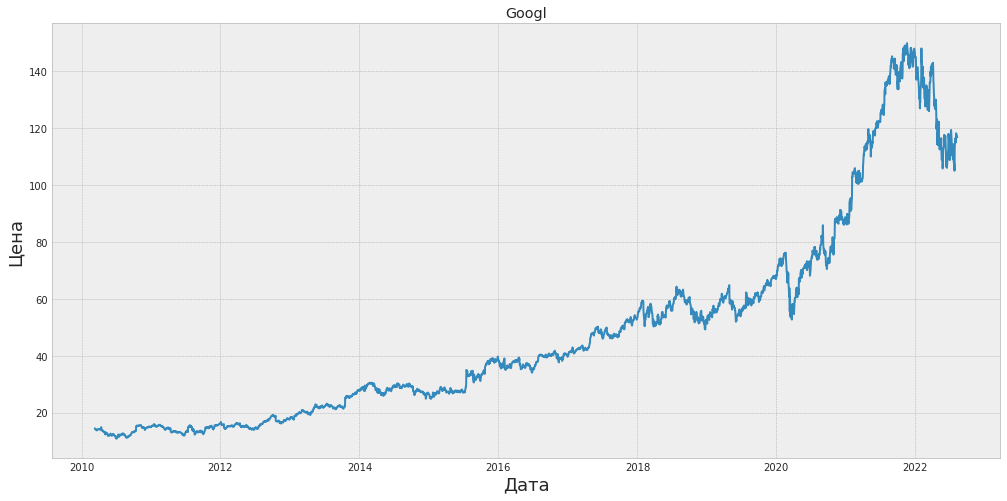

In [ ]:
# Выведем график цены с 2010 по 2022 год.
plt.figure(figsize=(17,8))
plt.title('Googl')
plt.plot(df_GOOGL['close'])
plt.xlabel('Дата', fontsize=18)
plt.ylabel('Цена', fontsize=18)
plt.show()

In [ ]:
# Задание гиперпараметров

CHANNEL_X = CHANNEL_NAMES                 # Отбор каналов входных данных
CHANNEL_Y = ['close']                     # Отбор каналов данных для предсказания
SEQ_LEN = 30                              # Длина прошедших данных для анализа
BATCH_SIZE = 2                            # Объем батча для генератора
TEST_LEN = 800                            # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки
col = 710

In [ ]:
data.shape[0]

3125

In [ ]:
# Формирование списков индексов каналов данных для входных и выходных выборок
chn_x = [CHANNEL_INDEX[c] for c in CHANNEL_X]
chn_y = [CHANNEL_INDEX[c] for c in CHANNEL_Y]

# Проверка результата
print(chn_x, chn_y)

[0, 1, 2, 3, 4] [3]


In [ ]:
# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными 
# варьируемый параметр, страховка от пересечения
data_train, data_test = data[:TRAIN_LEN], data[TRAIN_LEN + 2*SEQ_LEN:]

# Отбор входных данных
x_data_train, x_data_test = data_train[:, chn_x], data_test[:, chn_x]

# Масштабирование данных
x_scaler = MinMaxScaler()
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Отбор выходных данных
y_data_train, y_data_test = data_train[:, chn_y], data_test[:, chn_y]

# Масштабирование данных
y_scaler = MinMaxScaler()
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train, 
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test, 
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

Train data: (2325, 5), (2325, 1)
Test  data: (740, 5), (740, 1)
Train batch x: (2, 30, 5), y: (2, 1)


In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test, 
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_test.shape}, y: {y_test.shape}')

Test x: (710, 30, 5), y: (710, 1)


# ФунКции

In [ ]:
# Функция расчета результата прогнозирования сети (предсказания)

def get_pred(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler): # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [ ]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]


In [ ]:
# Функция визуализации результата предсказания сети и верных ответов

def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=CHANNEL_Y, # список имен каналов данных
                 title=''):
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    
    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn], 
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением

def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=30, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=CHANNEL_Y, 
              title=''): # список имен каналов данных
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)
    
    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
# Функция визуализации результата работы сети

def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=30, # параметры отображения графиков
             title=''):
  
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)
    
    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед 
    show_predict(y_pred[1:], y_true[:-1], start, length, 
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max, 
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [ ]:
# Функция обучения модели и отрисовки прогресса и оценки результатов 

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test, 
                   y_scaler, 
                   start=0, 
                   length=500, 
                   back_steps_max=30, 
                   title=''):
  
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen, 
                            epochs=epochs, 
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start, 
                 length=length, back_steps_max=back_steps_max, title=title)

# Сети

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 64)            1664      
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            20544     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 11, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 704)               0         
                                                                 
 dense (Dense)               (None, 100)               70500     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Обучение 50 эпох
Epoch 1/50
1148/1148 [==============================] - 20s 4ms/step - loss: 0.0045 - val_loss: 0.0124
Epoch 2/50
1148/1148 [==============================] - 4s 4ms/step - loss: 9.7200e-04 - val_loss: 0.0103
Epoch 3/50
1148/1148 [==============================] - 4s 4ms/step - loss: 0.0010 - val_loss: 0.0107
Epoch 4/50
1148/1148 [==============================] - 4s 4ms/step - loss: 6.9728e-04 - val_loss: 0.0068
Epoch 5/50
1148/1148 [==============================] - 4s 4ms/step - loss: 7.2407e-04 - val_loss: 0.0103
Epoch 6/50
1148/1148 [==============================] - 4s 4ms/step - loss: 6.3799e-04 - val_loss: 0.0094
Epoch 7/50
1148/1148 [==============================] - 4s 4ms/step - loss: 5.9703e-04 - val_loss: 0.0047
Epoch 8/50
1148/1148 [==============================] - 4s 4ms/step - loss: 4.6582e-04 - val_loss: 0.0099
Epoch 9/50
1148/1148 [==============================] - 4s 4ms/step - loss: 4.2748e-04 - val_loss: 0.0264
Epoch 10/50
1148/1148 [=============

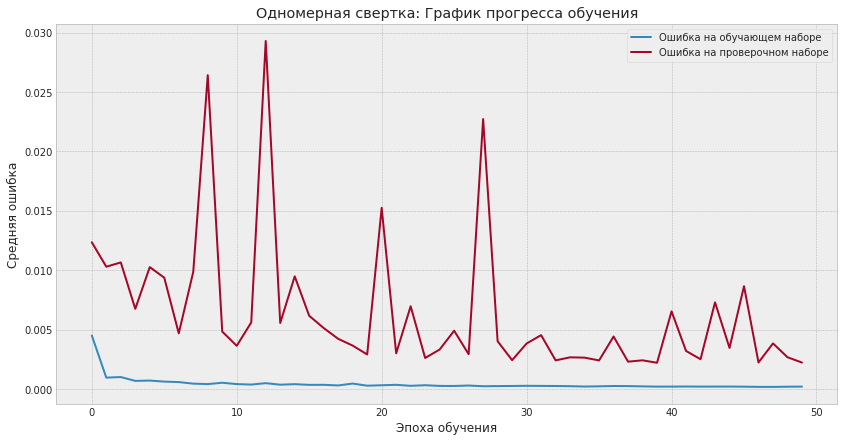

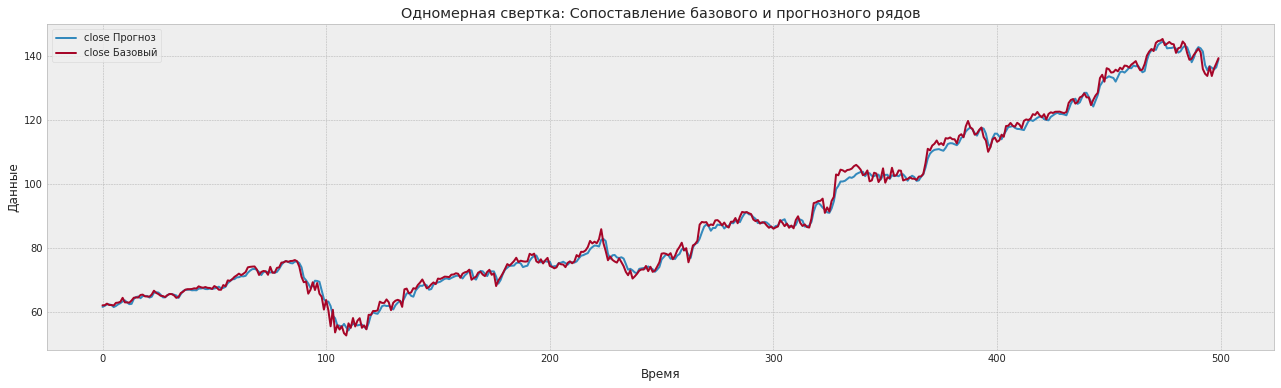

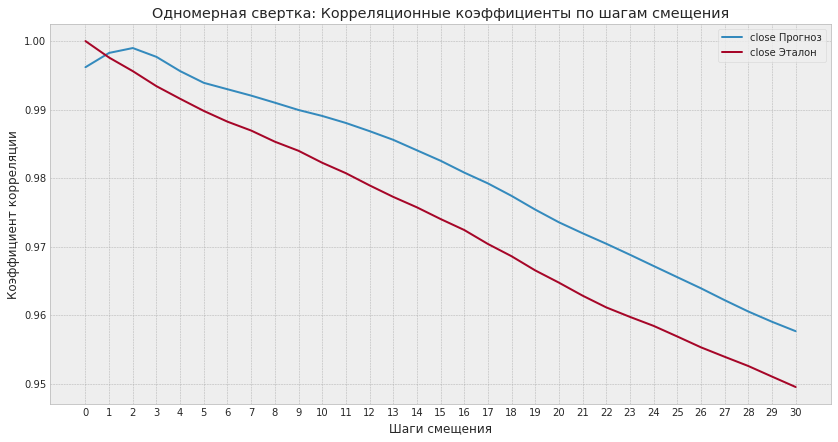

Обучение 20 эпох
Epoch 1/20
1148/1148 [==============================] - 5s 4ms/step - loss: 1.3549e-04 - val_loss: 0.0022
Epoch 2/20
1148/1148 [==============================] - 4s 4ms/step - loss: 1.3037e-04 - val_loss: 0.0021
Epoch 3/20
1148/1148 [==============================] - 5s 4ms/step - loss: 1.3034e-04 - val_loss: 0.0021
Epoch 4/20
1148/1148 [==============================] - 4s 4ms/step - loss: 1.2902e-04 - val_loss: 0.0023
Epoch 5/20
1148/1148 [==============================] - 5s 4ms/step - loss: 1.2626e-04 - val_loss: 0.0022
Epoch 6/20
1148/1148 [==============================] - 5s 4ms/step - loss: 1.3044e-04 - val_loss: 0.0021
Epoch 7/20
1148/1148 [==============================] - 5s 5ms/step - loss: 1.2602e-04 - val_loss: 0.0021
Epoch 8/20
1148/1148 [==============================] - 5s 4ms/step - loss: 1.2658e-04 - val_loss: 0.0023
Epoch 9/20
1148/1148 [==============================] - 4s 4ms/step - loss: 1.2511e-04 - val_loss: 0.0022
Epoch 10/20
1148/1148 [======

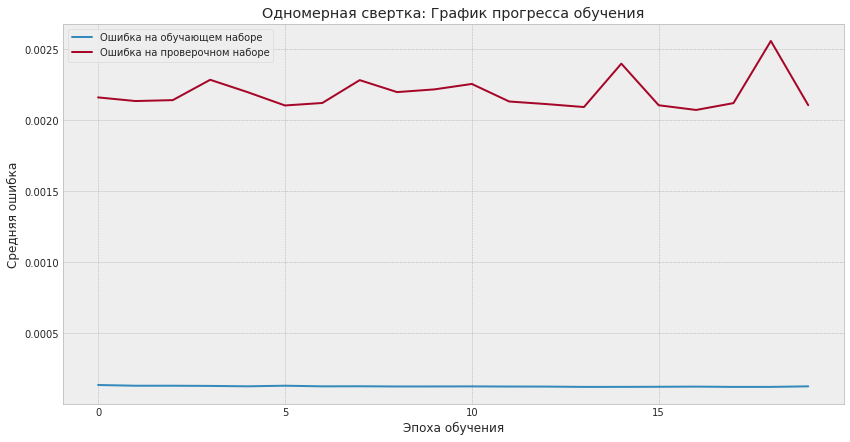

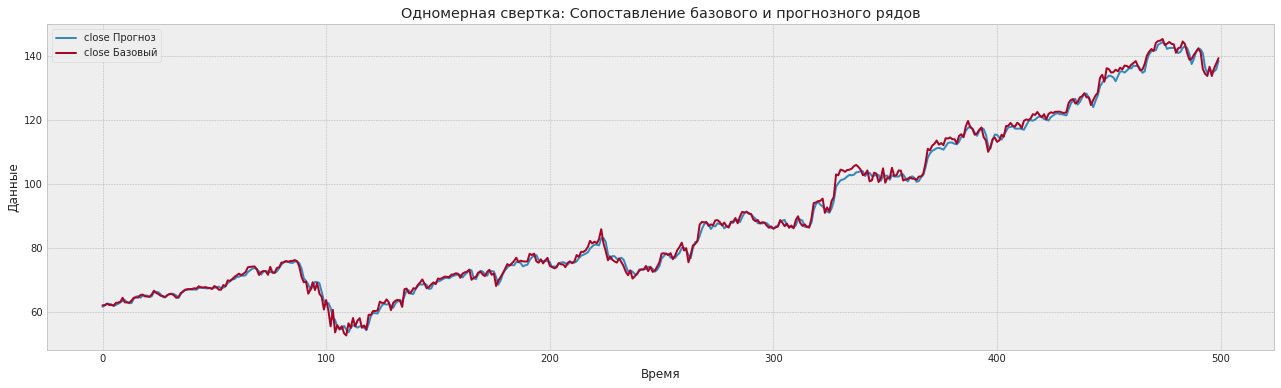

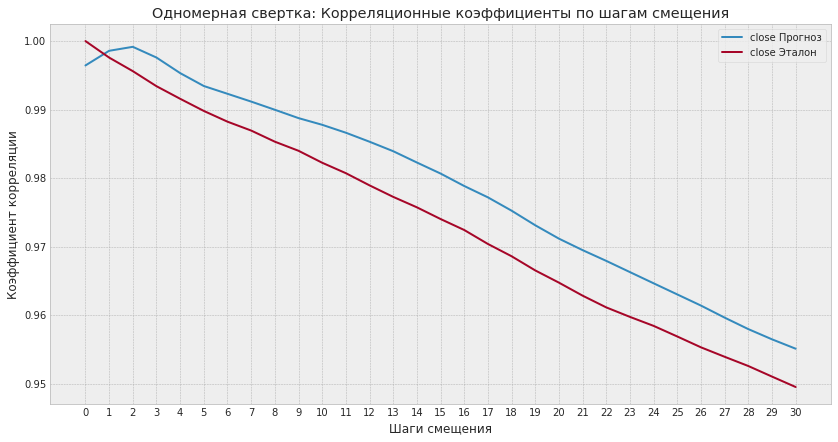

In [ ]:
# Модель с одномерной сверткой
model_conv = Sequential()
model_conv.add(Conv1D(64, 5, input_shape=x_test.shape[1:], activation='relu'))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Flatten())
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 50+20 эпох
train_eval_net(model_conv, train_datagen, val_datagen, [(50, Adam(lr=1e-4)),
                                                        (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 26, 50)            1300      
                                                                 
 flatten_1 (Flatten)         (None, 1300)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                13010     
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 14,321
Trainable params: 14,321
Non-trainable params: 0
_________________________________________________________________
Обучение 20 эпох
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1148/1148 [==============================] - 4s 3ms/step - loss: 0.0028 - val_loss: 0.0141
Epoch 2/20
1148/1148 [==============================] - 4s 3ms/step - loss: 0.0026 - val_loss: 0.0058
Epoch 3/20
1148/1148 [==============================] - 4s 3ms/step - loss: 0.0014 - val_loss: 0.0169
Epoch 4/20
1148/1148 [==============================] - 4s 3ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 5/20
1148/1148 [==============================] - 4s 3ms/step - loss: 9.3675e-04 - val_loss: 0.0067
Epoch 6/20
1148/1148 [==============================] - 4s 3ms/step - loss: 9.1448e-04 - val_loss: 0.0033
Epoch 7/20
1148/1148 [==============================] - 4s 3ms/step - loss: 8.5800e-04 - val_loss: 0.0028
Epoch 8/20
1148/1148 [==============================] - 4s 3ms/step - loss: 5.8600e-04 - val_loss: 0.0077
Epoch 9/20
1148/1148 [==============================] - 4s 3ms/step - loss: 6.4585e-04 - val_loss: 0.0060
Epoch 10/20
1148/1148 [==============================] - 4s 3ms/step - lo

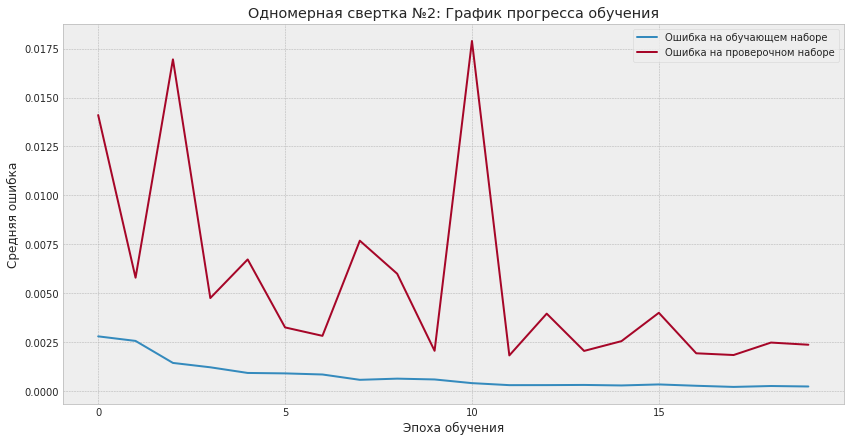

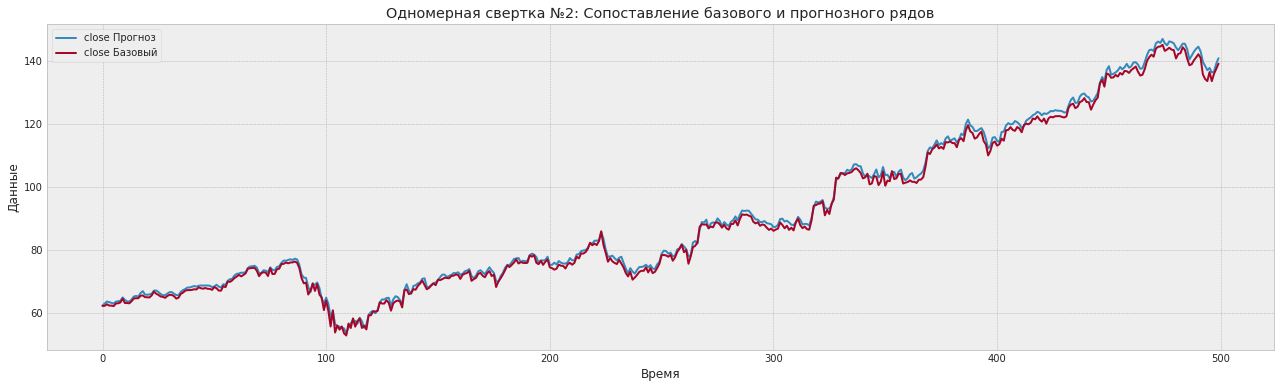

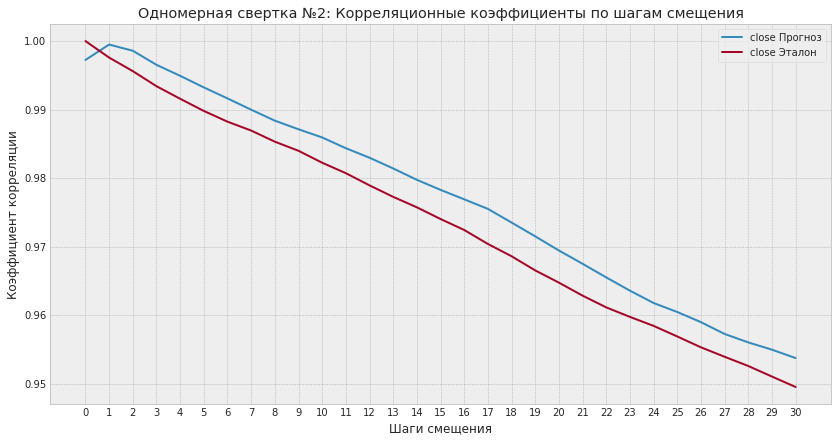

Обучение 20 эпох
Epoch 1/20
1148/1148 [==============================] - 5s 4ms/step - loss: 1.1224e-04 - val_loss: 0.0015
Epoch 2/20
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0782e-04 - val_loss: 0.0016
Epoch 3/20
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0374e-04 - val_loss: 0.0015
Epoch 4/20
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0539e-04 - val_loss: 0.0020
Epoch 5/20
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0465e-04 - val_loss: 0.0015
Epoch 6/20
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0591e-04 - val_loss: 0.0015
Epoch 7/20
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0527e-04 - val_loss: 0.0015
Epoch 8/20
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0559e-04 - val_loss: 0.0023
Epoch 9/20
1148/1148 [==============================] - 4s 3ms/step - loss: 1.0221e-04 - val_loss: 0.0015
Epoch 10/20
1148/1148 [======

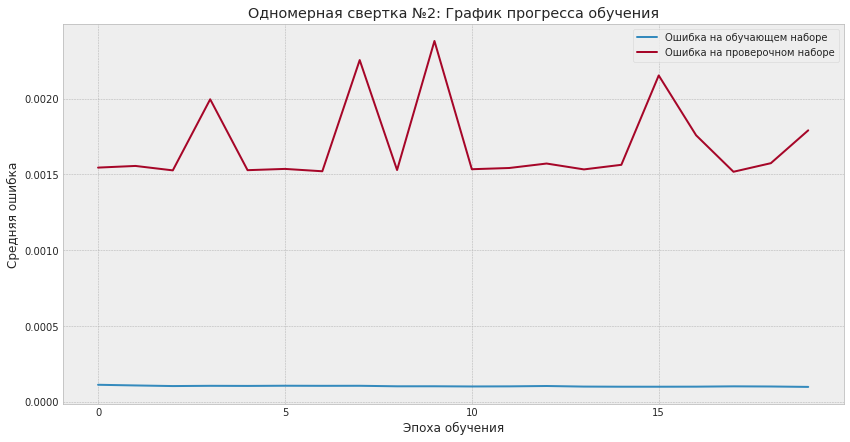

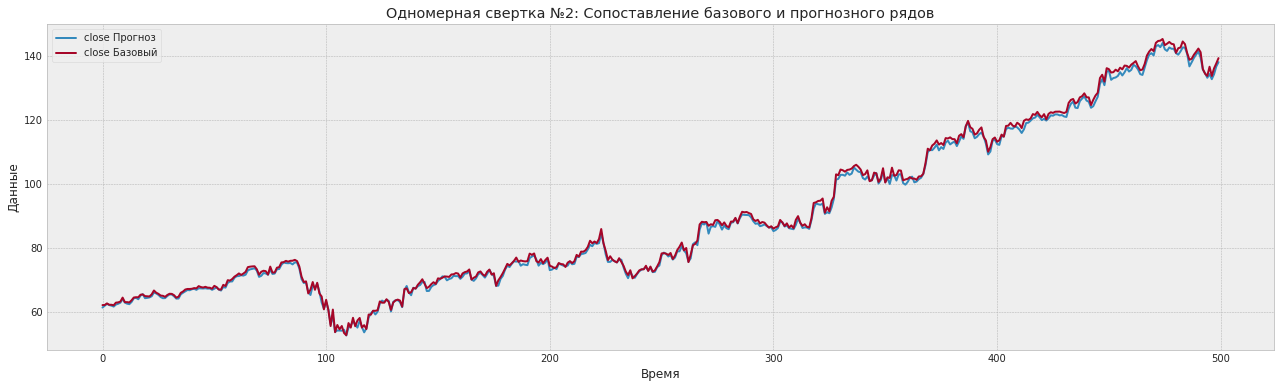

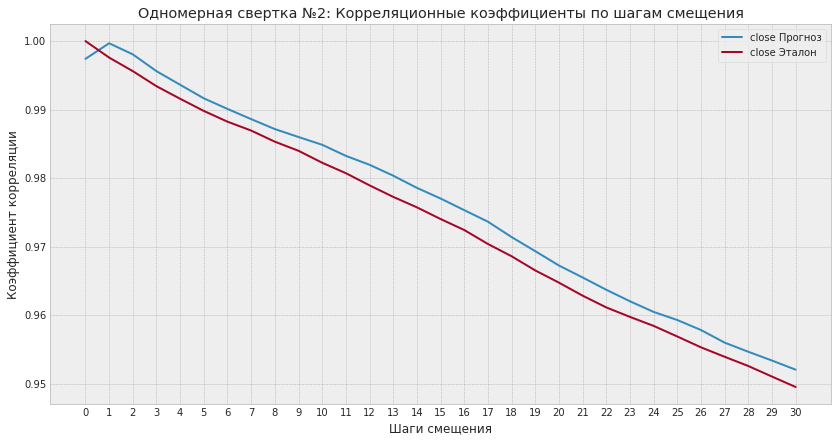

In [ ]:
# Упрощенная модель с одномерной сверткой
model_conv_2 = Sequential()
model_conv_2.add(Conv1D(50, 5, input_shape=x_test.shape[1:], activation='linear'))
model_conv_2.add(Flatten())
model_conv_2.add(Dense(10, activation='linear'))
model_conv_2.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 2x20 эпох
train_eval_net(model_conv_2, train_datagen, val_datagen, [(20, Adam(lr=1e-4)),
                                                          (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Одномерная свертка №2')

### Рекуррентная сеть (LSTM)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 40)            7360      
                                                                 
 lstm_1 (LSTM)               (None, 20)                4880      
                                                                 
 dense_4 (Dense)             (None, 25)                525       
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 12,791
Trainable params: 12,791
Non-trainable params: 0
_________________________________________________________________
Обучение 20 эпох
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1148/1148 [==============================] - 13s 8ms/step - loss: 0.0163 - val_loss: 0.6433
Epoch 2/20
1148/1148 [==============================] - 8s 7ms/step - loss: 7.5807e-04 - val_loss: 0.5873
Epoch 3/20
1148/1148 [==============================] - 8s 7ms/step - loss: 6.5445e-04 - val_loss: 0.5600
Epoch 4/20
1148/1148 [==============================] - 8s 7ms/step - loss: 6.3851e-04 - val_loss: 0.5305
Epoch 5/20
1148/1148 [==============================] - 8s 7ms/step - loss: 5.8616e-04 - val_loss: 0.4590
Epoch 6/20
1148/1148 [==============================] - 8s 7ms/step - loss: 5.5411e-04 - val_loss: 0.4611
Epoch 7/20
1148/1148 [==============================] - 8s 7ms/step - loss: 4.8897e-04 - val_loss: 0.4135
Epoch 8/20
1148/1148 [==============================] - 9s 8ms/step - loss: 5.2714e-04 - val_loss: 0.4188
Epoch 9/20
1148/1148 [==============================] - 8s 7ms/step - loss: 4.6970e-04 - val_loss: 0.3757
Epoch 10/20
1148/1148 [==============================] - 8s 

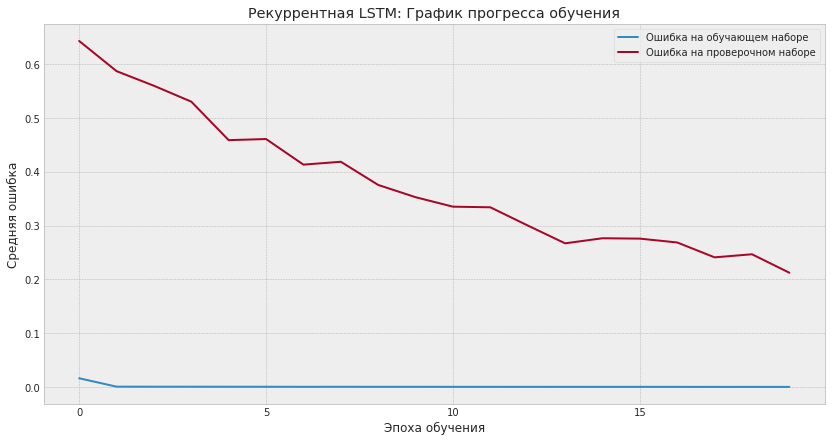

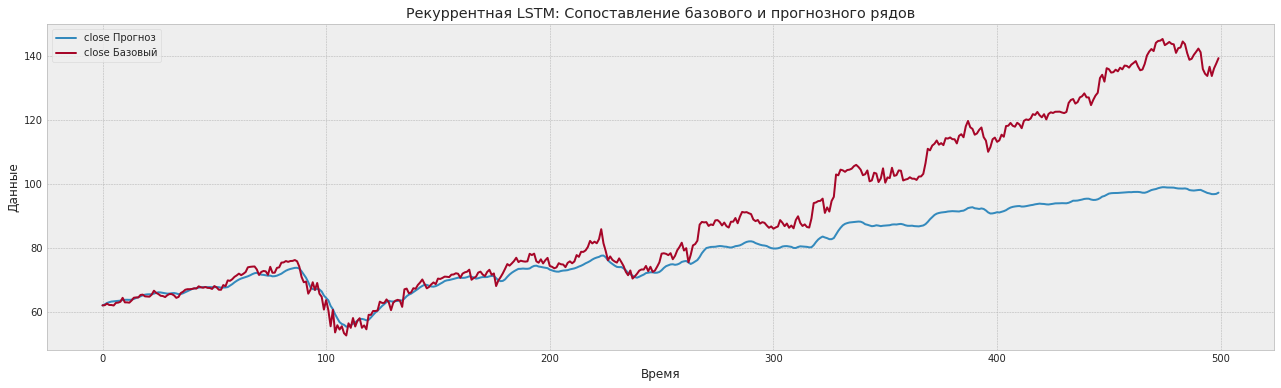

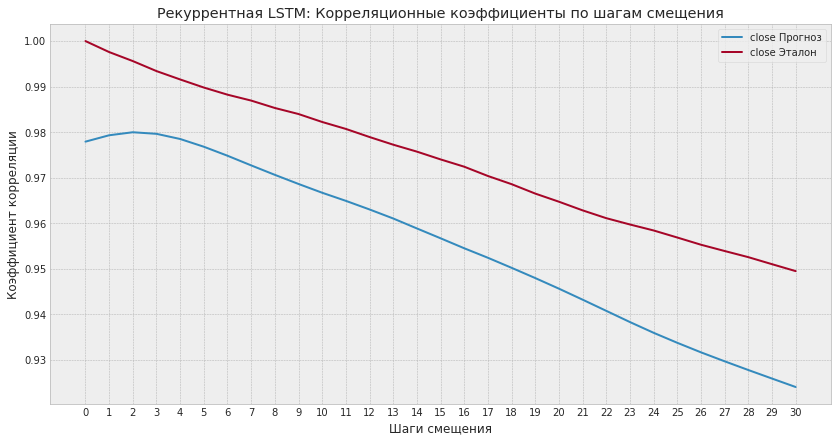

Обучение 20 эпох
Epoch 1/20
1148/1148 [==============================] - 12s 8ms/step - loss: 2.3579e-04 - val_loss: 0.2269
Epoch 2/20
1148/1148 [==============================] - 9s 7ms/step - loss: 2.3555e-04 - val_loss: 0.2264
Epoch 3/20
1148/1148 [==============================] - 9s 7ms/step - loss: 2.3333e-04 - val_loss: 0.2225
Epoch 4/20
1148/1148 [==============================] - 9s 7ms/step - loss: 2.3295e-04 - val_loss: 0.2216
Epoch 5/20
1148/1148 [==============================] - 9s 8ms/step - loss: 2.2829e-04 - val_loss: 0.2220
Epoch 6/20
1148/1148 [==============================] - 9s 7ms/step - loss: 2.2701e-04 - val_loss: 0.2229
Epoch 7/20
1148/1148 [==============================] - 9s 7ms/step - loss: 2.2248e-04 - val_loss: 0.2181
Epoch 8/20
1148/1148 [==============================] - 9s 7ms/step - loss: 2.2282e-04 - val_loss: 0.2189
Epoch 9/20
1148/1148 [==============================] - 9s 7ms/step - loss: 2.2099e-04 - val_loss: 0.2228
Epoch 10/20
1148/1148 [=====

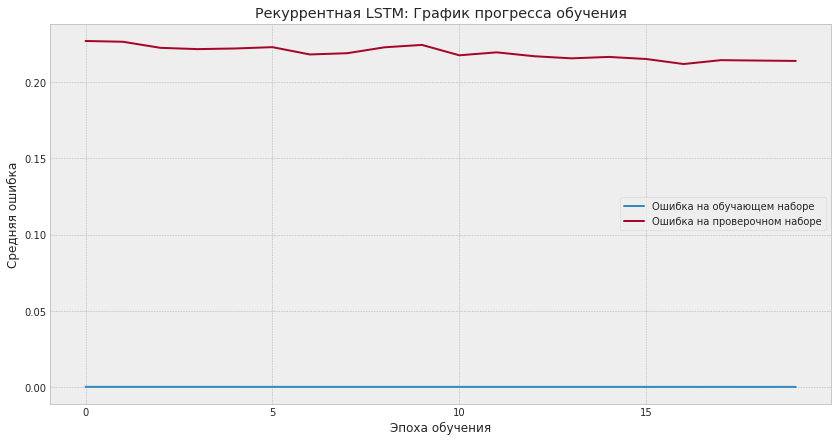

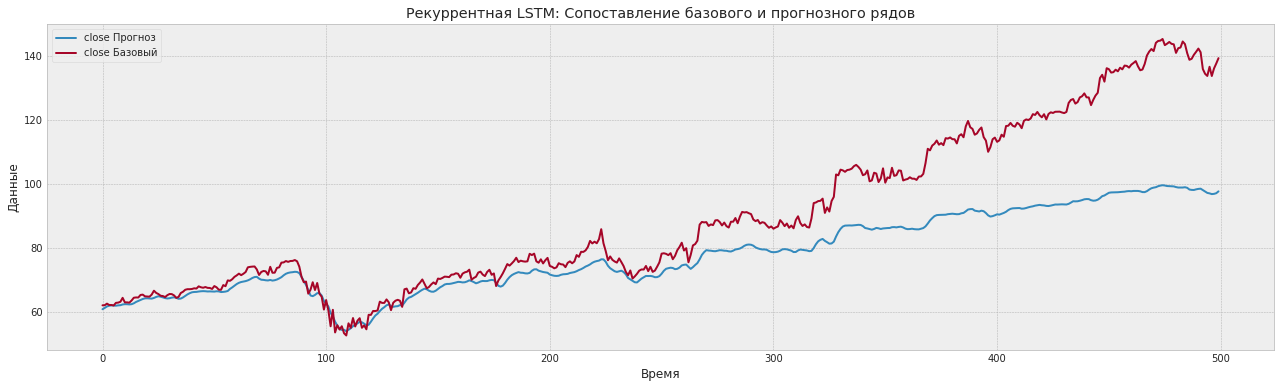

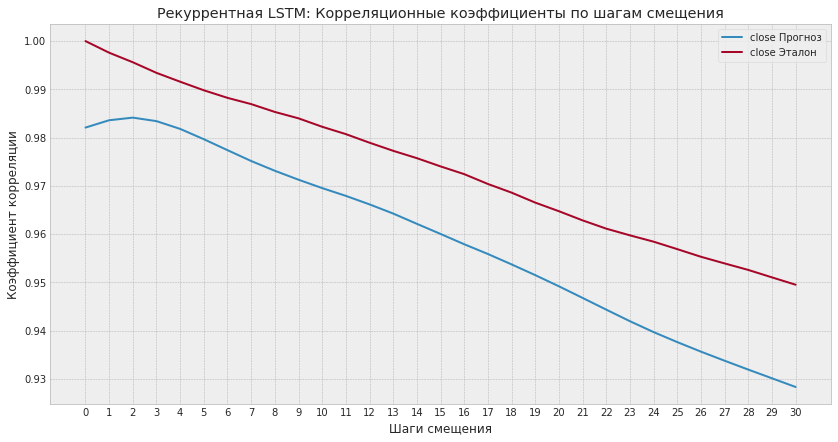

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(40, return_sequences=True, input_shape= (x_test.shape[1:])))
model_lstm.add(LSTM(20, return_sequences=False))
model_lstm.add(Dense(25,activation='relu'))
model_lstm.add(Dense(y_test.shape[1],activation='linear'))


# Обучение модели 20 эпох
train_eval_net(model_lstm, train_datagen, val_datagen, [(20, Adam(lr=1e-4)),
                                                          (20, Adam(lr=1e-5))],
               x_test, y_test, y_scaler, title='Рекуррентная LSTM')

In [ ]:
# Пересохранение обученной модели полностью (веса и архитектура) после всех эпох
model_conv.save('/content/drive/MyDrive/Предсказание акций/model_conv_all.h5')
model_conv_2.save('/content/drive/MyDrive/Предсказание акций/model_conv_2_all.h5')
model_lstm.save('/content/drive/MyDrive/Предсказание акций/model_lstm_all.h5')

# Предикт

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model
model_conv_2 = load_model('/content/drive/MyDrive/Предсказание акций/model_conv_2_all.h5')

In [ ]:
y_pred_unscaled = y_scaler.inverse_transform(model_conv_2.predict(x_test))
y_test_unscaled = y_scaler.inverse_transform(y_test)
y_pred, y_true = get_pred(model_conv_2, x_test, y_test, y_scaler)

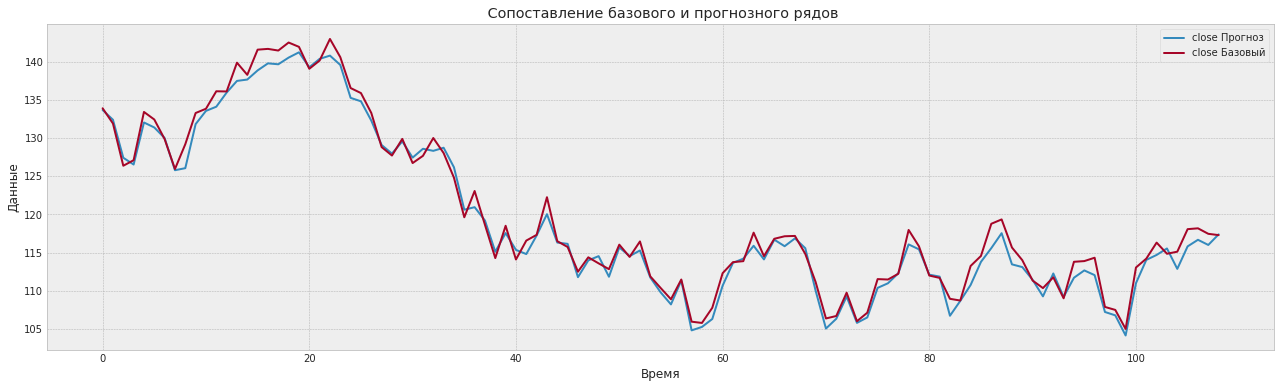

In [ ]:
show_predict(y_pred[1:], y_true[:-1],600, 710, 
                 title=' Сопоставление базового и прогнозного рядов')

In [ ]:
# Получить среднеквадратичную ошибку (RMSE)
rmse = np.sqrt(np.mean(((y_pred - y_true) ** 2)))
print("Среднеквадратичная ошибка с тестовыми данными ",rmse)

Среднеквадратичная ошибка с тестовыми данными  2.2075406152320003


In [ ]:
# Смотрим данные.
data = df_GOOGL_pred.insert(0, 'predict',y_pred, allow_duplicates = False)
data = df_GOOGL_pred.drop(columns=['ticker','adjclose','open','high','low','adjclose','volume'])
data.tail(10)

,predict,close
2012-12-20,104.165398,18.077078
2012-12-21,111.007317,17.908659
2012-12-24,114.054604,17.755255
2012-12-26,114.706329,17.739489
2012-12-27,115.553703,17.674925
2012-12-28,112.881493,17.517769
2012-12-31,115.826881,17.702202
2013-01-02,116.688011,18.099348
2013-01-03,116.011620,18.109859
2013-01-04,117.400391,18.467718


In [ ]:
# plt.figure(figsize=(8000,1000))
# mpf.plot(Googl[600:],type='candle',mav=(3,6,9),volume=True)
# plt.style.use('fivethirtyeight')